In [1]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [2]:
from langgraph.graph import StateGraph, START, END
from langchain_openai.chat_models import ChatOpenAI

In [6]:
# 通过 dict，State 每步都要完整传递

builder = StateGraph(dict)


def node_1(state):
    print(f"node_1: {state}")
    return {"x": state["x"] + 1}


def node_2(state):
    print(f"node_2: {state}")
    return {"y": state["y"] + 2}


builder.add_node(node_1)
builder.add_node(node_2)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()

graph.invoke({"x": 0, "y": 0})

node_1: {'x': 0, 'y': 0}
node_2: {'x': 1}


KeyError: 'y'

In [12]:
# 通过 TypedDict 每步只需返回更新的值

from typing import TypedDict


class State(TypedDict):
    x: int
    y: int


builder = StateGraph(State)


def node_1(state):
    print(f"node_1: {state}")
    return {"x": state["x"] + 1}


def node_2(state):
    print(f"node_2: {state}")
    return {"y": state["y"] + 2}


builder.add_node(node_1)
builder.add_node(node_2)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()

graph.invoke({"x": 0, "y": 0})

node_1: {'x': 0, 'y': 0}
node_2: {'x': 1, 'y': 0}


{'x': 1, 'y': 2}

In [14]:
# reducer

# 通过 TypedDict 每步只需返回更新的值

import operator
from typing import Annotated, TypedDict


class State(TypedDict):
    messages: Annotated[list[dict], operator.add]


builder = StateGraph(State)


def addition(state: State):
    print(f"node_1: {state}")
    return {"messages": [{"x": state["messages"][-1]["x"] + 1}]}


def subtraction(state):
    print(f"node_2: {state}")
    return {"messages": [{"x": state["messages"][-1]["x"] - 2}]}


builder.add_node(addition)
builder.add_node(subtraction)

builder.add_edge(START, "addition")
builder.add_edge("addition", "subtraction")
builder.add_edge("subtraction", END)

graph = builder.compile()

graph.invoke({"messages": [{"x": 10}]})

node_1: {'messages': [{'x': 10}]}
node_2: {'messages': [{'x': 10}, {'x': 11}]}


{'messages': [{'x': 10}, {'x': 11}, {'x': 9}]}

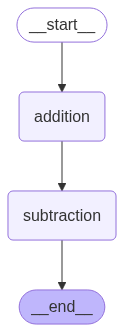

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 结合 llm

In [23]:
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages

llm = ChatOpenAI(model="qwen-plus")


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


def chat_with_model(state: State):
    print(state)
    print("---------------")
    response = llm.invoke(state["messages"])
    return {"messages": [response]}


def convert_messages(state: State):
    EXTRACTION_PROMPT = """
    You are a data extraction specialist tasked with retrieving key information from a text.
    Extract such information for the provided text and output it in JSON format. Outline the key data points extracted.
    """
    print(state)
    print("---------------")
    messages = [
        SystemMessage(content=EXTRACTION_PROMPT),
        HumanMessage(content=state["messages"][-1].content),
    ]
    response = llm.invoke(messages)
    return {"messages": [response]}


graph = (
    StateGraph(State)
    .add_node(chat_with_model)
    .add_node(convert_messages)
    .add_edge("chat_with_model", "convert_messages")
    .set_entry_point("chat_with_model")
    .compile()
)

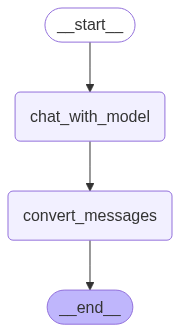

In [24]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
result = graph.invoke({"messages": [HumanMessage(content="你好，请你介绍一下你自己")]})
result

{'messages': [HumanMessage(content='你好，请你介绍一下你自己', additional_kwargs={}, response_metadata={}, id='ca9f62e0-0e25-4d24-a107-1bf5b10365df')]}
---------------
{'messages': [HumanMessage(content='你好，请你介绍一下你自己', additional_kwargs={}, response_metadata={}, id='ca9f62e0-0e25-4d24-a107-1bf5b10365df'), AIMessage(content='你好！我是Qwen（通义千问），是阿里巴巴集团旗下的通义实验室自主研发的超大规模语言模型。我可以帮助你回答问题、创作文字，比如写故事、写公文、写邮件、写剧本、逻辑推理、编程等等，还能表达观点，玩游戏等。我支持多种语言，包括但不限于中文、英文、德语、法语、西班牙语等。\n\n如果你有任何问题或需要帮助，随时告诉我！😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 17, 'total_tokens': 110, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'qwen-plus', 'system_fingerprint': None, 'id': 'chatcmpl-20d0eb38-affb-9cc9-9bc5-b5b1de42332a', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--888fc5d9-eeae-42d8-8b7e-ed2e4a92fd12-0', usage_metadata={'input_tokens': 17, 'output_tokens': 93

{'messages': [HumanMessage(content='你好，请你介绍一下你自己', additional_kwargs={}, response_metadata={}, id='ca9f62e0-0e25-4d24-a107-1bf5b10365df'),
  AIMessage(content='你好！我是Qwen（通义千问），是阿里巴巴集团旗下的通义实验室自主研发的超大规模语言模型。我可以帮助你回答问题、创作文字，比如写故事、写公文、写邮件、写剧本、逻辑推理、编程等等，还能表达观点，玩游戏等。我支持多种语言，包括但不限于中文、英文、德语、法语、西班牙语等。\n\n如果你有任何问题或需要帮助，随时告诉我！😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 17, 'total_tokens': 110, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'qwen-plus', 'system_fingerprint': None, 'id': 'chatcmpl-20d0eb38-affb-9cc9-9bc5-b5b1de42332a', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--888fc5d9-eeae-42d8-8b7e-ed2e4a92fd12-0', usage_metadata={'input_tokens': 17, 'output_tokens': 93, 'total_tokens': 110, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}),
  AIMessage(content='### 提取的关键数据点：\n1. **名称**：Qwen（通义千问）\n2

In [26]:
print(result["messages"][-1].content)

### 提取的关键数据点：
1. **名称**：Qwen（通义千问）
2. **开发者**：阿里巴巴集团通义实验室
3. **类型**：超大规模语言模型
4. **功能**：
   - 回答问题
   - 创作文字（如写故事、写公文、写邮件、写剧本等）
   - 逻辑推理
   - 编程
   - 表达观点
   - 玩游戏
5. **支持语言**：中文、英文、德语、法语、西班牙语等

### JSON 格式输出：

```json
{
  "name": "Qwen（通义千问）",
  "developer": "阿里巴巴集团通义实验室",
  "type": "超大规模语言模型",
  "functions": [
    "回答问题",
    "创作文字",
    "逻辑推理",
    "编程",
    "表达观点",
    "玩游戏"
  ],
  "supported_languages": [
    "中文",
    "英文",
    "德语",
    "法语",
    "西班牙语"
  ]
}
```


## MessageGraph

In [ ]:
from langgraph.graph import MessageGraph

graph = (
    MessageGraph()
    .add_node("chatbot", lambda state: [("assistant", "你好")])
    .set_entry_point("chatbot")
    .compile()
)

In [41]:
graph.invoke([("user", "Hi there.")])

[HumanMessage(content='Hi there.', additional_kwargs={}, response_metadata={}, id='f3ad3d57-babd-4b10-a82e-446e88dd8832'),
 AIMessage(content='你好', additional_kwargs={}, response_metadata={}, id='73291244-c943-43e9-bb21-1d884d7cc6fb')]